<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px; font-family: garamond;">

<h1><b> Binary Prediction of Poisonous Mushrooms </b></h1>

<a href="https://www.kaggle.com/competitions/playground-series-s4e8">
    <b style="color: #168188;"><u>Playground Series - Season 4, Episode 8</u></b>
</a>

<div style="margin-top: 20px; text-align:center;">
    <img style="min-width: 75%; padding: " src="./data/header.png" alt="Playground Series S4E8">
</div>

<b>Overview</b>
Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

<b>Your Goal:</b> The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

<b>Dataset Description</b>
The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

<b>Note:</b> Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.

<b>Files (297.82 MB)</b>

<li> train.csv - the training dataset; class is the binary target (either e or p)        </li>
<li> test.csv - the test dataset; your objective is to predict target class for each row </li>
<li> sample_submission.csv - a sample submission file in the correct format              </li>
</div>

<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Tabel of Contents</b></h1>
</div>

- <a href="#libraries">1. Import Necessary Libraries</a>
- <a href="#data">2. Reading Training Data</a>
    - <a href="#display">2.1 Display Data</a>
    - <a href="#info">2.2 Show More Info</a>
- <a href="#preprocess">3. Preprocess Data and Cleaning</a>
    - <a href="#duplicated">3.1 Remove Duplicated</a> 
    - <a href="#nanvalue">3.2 Check For NaN values</a>
    - <a href="#rare">3.3 Handle Rare Categories</a>
    - <a href="#num">3.4 Numerical Columns</a> 
    - <a href="#impute">3.5 Impute Missing Data</a> 
- <a href="#nplots">4. Plotting Training Data</a>
    - <a href="#corr">4.1 Feature Correlation</a>
    - <a href="#hist">4.2 Distribution Histogram</a>
    - <a href="#numrels">4.3 Investigating Relationships (Numerical)</a>
    - <a href="#catrels">4.4 Investigating Relationships (Category)</a>
    - <a href="#outliers">4.5 Check For Outliers</a>
    - <a href="#response">4.6 Response Variable</a>
- <a href="#preproces">5. Preproces and Model</a>
    - <a href="#split">5.1 Train Test Split</a>
    - <a href="#xgb">5.2 X Gradient Boosting</a>
    - <a href="#light">5.3 Light Gradient Boosting</a>
    - <a href="#cat">5.4 Cat Boosting Classifier</a>
    - <a href="#confusion">5.5 Plot Confusion Matrix</a>
- <a href="#cross">6. Cross Validation</a>
- <a href="#submission">7. Send Submission</a>

<a id="libraries"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Import Necessary Libraries</b></h1>
</div>

In [ ]:
# Install pip modules
%pip install --upgrade pip --break-system-packages
%pip install -r requirements.txt --break-system-packages

In [23]:
# Import all libraries
import os
import numpy as np 
import pandas as pd
import pickle as pkl
import seaborn as sns
import warnings as wn
import matplotlib.pyplot as plt

from scipy import stats
from prettytable import PrettyTable
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report 
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer 

In [2]:
# Ignore all warnings
wn.filterwarnings('ignore')

In [3]:
# Set all variables paths 

_plots = './plots/'
_tested = './tested/'
_test = './data/test.csv'
_train = './data/train.csv'
_info = './model/model.docx'
_model = './model/model.pkl'
_submission = './data/sample_submission.csv'

In [4]:
# Set the jupyter notebook to disable debugger validation
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

<a id="data"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Reading Training Data</b></h1>
</div>

In [5]:
# Simplify the process of integrating large CSV

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file, **kwargs):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, **kwargs)
    df = reduce_mem_usage(df)
    return df

In [6]:
# Read the training datasets 
train = import_data(_train, index_col="id")

Memory usage of dataframe is 523.17 MB
Memory usage after optimization is: 469.66 MB
Decreased by 10.2%


<a id="display"></a>
<div style="color: #207881; background-color: #104452; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Display Data</b></h3>
</div>

In [7]:
# Display the first n rows of training
train.head(n=10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.796875,f,s,u,f,a,c,w,4.511719,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.511719,x,h,o,f,a,c,n,4.789062,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.941406,f,s,b,f,x,c,w,6.851562,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.880859,f,y,g,f,s,NaN,g,4.160156,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.851562,x,l,w,f,d,NaN,w,3.369141,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
5,p,4.300781,x,t,n,f,s,c,n,5.910156,...,NaN,NaN,w,NaN,n,t,z,NaN,d,a
6,e,9.648438,p,y,w,f,e,c,k,19.062500,...,NaN,s,w,NaN,NaN,t,e,NaN,g,w
7,p,4.550781,x,e,e,f,a,NaN,y,8.312500,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
8,p,7.359375,f,h,e,f,x,d,w,5.769531,...,b,NaN,w,NaN,NaN,f,f,NaN,d,a


<a id="info"></a>
<div style="color: #207881; background-color: #104452; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Show More Info</b></h3>
</div>

In [ ]:
# Describe the data
train.describe(include=['object']).T

,count,unique,top,freq
class,3116945,2,p,1705396
cap-shape,3116905,74,x,1436026
cap-surface,2445922,83,t,460777
cap-color,3116933,78,n,1359542
does-bruise-or-bleed,3116937,26,f,2569743
gill-attachment,2593009,78,a,646034
gill-spacing,1858510,48,c,1331054
gill-color,3116888,63,w,931538
stem-root,359922,38,b,165801
stem-surface,1136084,60,s,327610


In [ ]:
# Display more info about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float16
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float16
 10  stem-width            float16
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float16(3), object(18)
memory usage: 469.7+ MB


In [ ]:
# Set the datatype of each column for memory eficiency

for col in train.columns:
    if train[col].dtype == 'object':
        print(f'Column {col} has {train[col].nunique()} unique values')

Column class has 2 unique values
Column cap-shape has 74 unique values
Column cap-surface has 83 unique values
Column cap-color has 78 unique values
Column does-bruise-or-bleed has 26 unique values
Column gill-attachment has 78 unique values
Column gill-spacing has 48 unique values
Column gill-color has 63 unique values
Column stem-root has 38 unique values
Column stem-surface has 60 unique values
Column stem-color has 59 unique values
Column veil-type has 22 unique values
Column veil-color has 24 unique values
Column has-ring has 23 unique values
Column ring-type has 40 unique values
Column spore-print-color has 32 unique values
Column habitat has 52 unique values
Column season has 4 unique values


In [ ]:
# Display proportion on each column 

table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Train Missing %']
for column in train.columns:
    data_type = str(train[column].dtype)
    non_null_count_train= np.round(100-train[column].count()/train.shape[0]*100,1)
    table.add_row([column, data_type, non_null_count_train])
print(table)

+----------------------+-----------+-----------------+
|       Feature        | Data Type | Train Missing % |
+----------------------+-----------+-----------------+
|        class         |   object  |       0.0       |
|     cap-diameter     |  float16  |       0.0       |
|      cap-shape       |   object  |       0.0       |
|     cap-surface      |   object  |       21.5      |
|      cap-color       |   object  |       0.0       |
| does-bruise-or-bleed |   object  |       0.0       |
|   gill-attachment    |   object  |       16.8      |
|     gill-spacing     |   object  |       40.4      |
|      gill-color      |   object  |       0.0       |
|     stem-height      |  float16  |       0.0       |
|      stem-width      |  float16  |       0.0       |
|      stem-root       |   object  |       88.5      |
|     stem-surface     |   object  |       63.6      |
|      stem-color      |   object  |       0.0       |
|      veil-type       |   object  |       94.9      |
|      vei

<a id="preprocess"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Preprocess Data and Cleaning</b></h1>
</div>

<a id="duplicated"></a>
<div style="color: #207881; background-color: #104452; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Remove Duplicated</b></h3>
</div>

In [8]:
# Check for dublicates
print(train.duplicated().sum())
train = train.drop_duplicates()
print(f'New training data: {train.shape}')

119
New training data: (3116826, 21)


<a id="nanvalue"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Check For NaN values</b></h3>
</div>

In [13]:
# Verify if there are null values

print("Every missing value by column:")
print(train.isnull().sum())

Every missing value by column:
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              670995
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523910
gill-spacing            1258371
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2756917
stem-surface            1980769
stem-color                   38
veil-type               2957379
veil-color              2740838
has-ring                     24
ring-type                128871
spore-print-color       2849564
habitat                      45
season                        0
dtype: int64


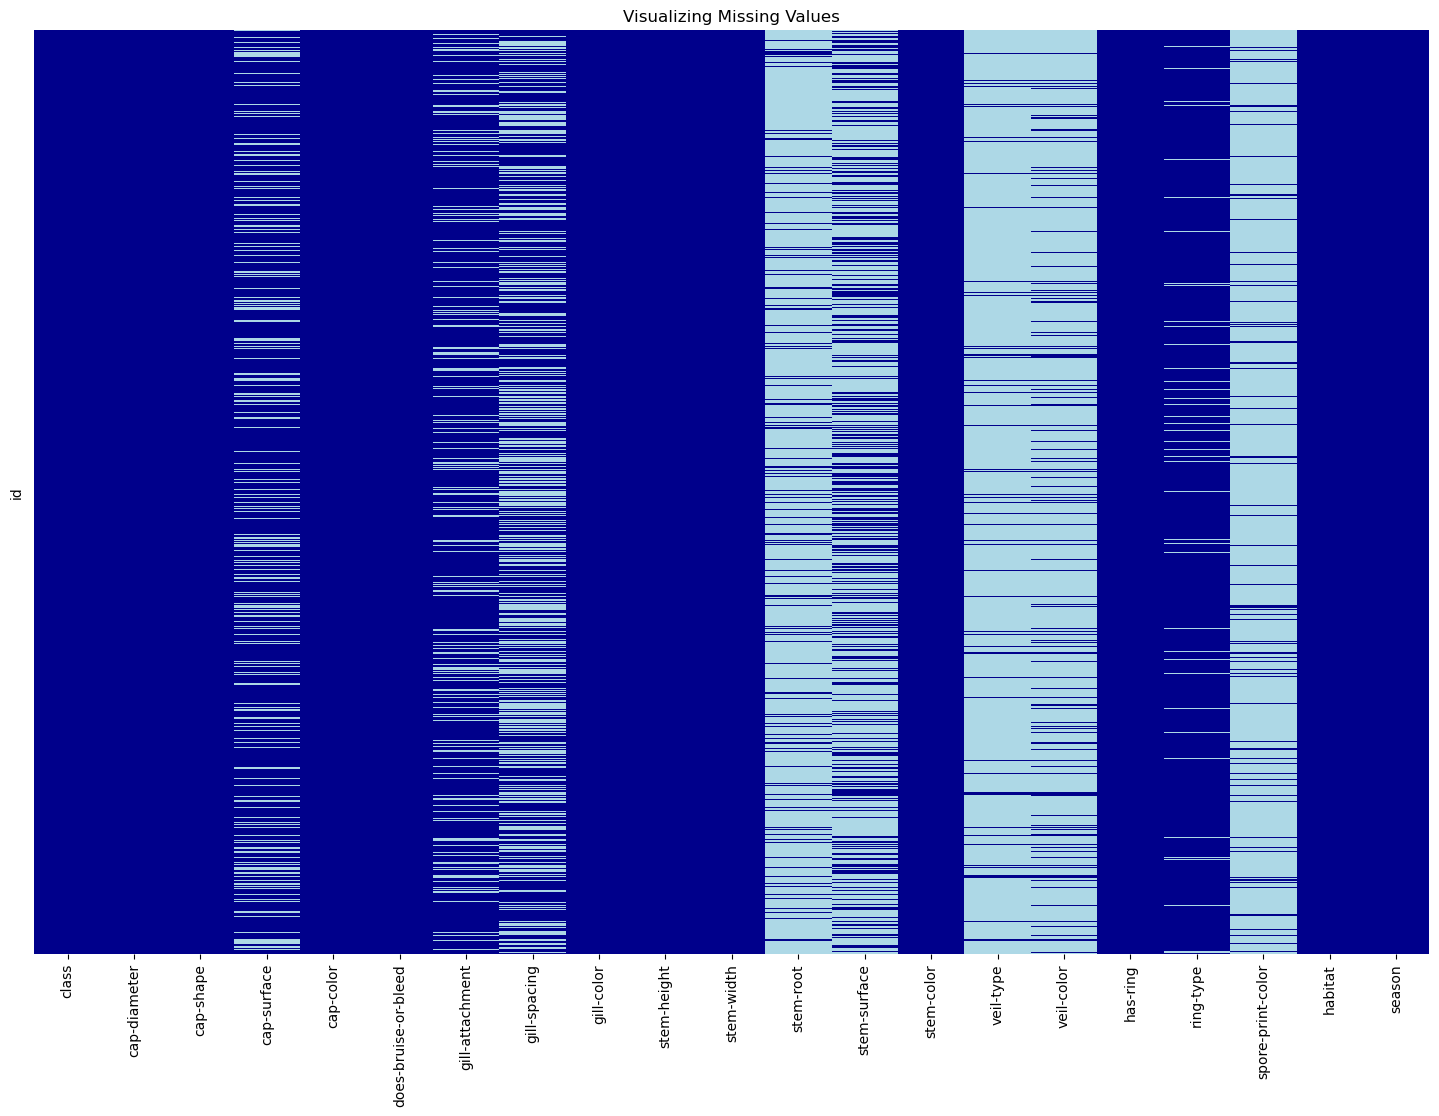

In [37]:
# Create a heatmap to visualize missing values

custom_pallete = ['darkblue', 'lightblue']
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(train.isnull(), 
    cbar=False,     
    cmap=custom_pallete, 
    yticklabels=False
);
plt.show()

<a id="rare"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Handle Rare Categories</b></h3>
</div>

In [9]:
# Remove columns with more then 90% missing values

missing = train.isnull().median()
drop = missing[missing > 0.9].index
train = train.drop(drop, axis=1)

In [10]:
# Define the target column
target = 'class'
cat_columns = train.select_dtypes(include=['object']).columns
num_columns = train.select_dtypes(exclude=['object']).columns

In [11]:
# Define a function to identify and replace infrequent categories

def remove_categories(df, column, threshold=70):
    infrequent = df[column].value_counts()[lambda x: x <= threshold].index
    df[column] = df[column].where(~df[column].isin(infrequent), "None")
    return df

for col in cat_columns:
    train = remove_categories(train, col, threshold=70)

<a id="num"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Numerical Columns</b></h3>
</div>

In [12]:
# Filter num_columns to include only numeric columns

numeric_cols = train[num_columns].select_dtypes(include=[np.number]).columns
skewness = train[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
medians = train[numeric_cols].median()
train[numeric_cols] = train[numeric_cols].fillna(medians)

<a id="impute"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Impute Missing Data</b></h3>
</div>

In [13]:
# Impute any missing values with 'Unknown'
train = train.fillna("None")

In [13]:
# New training data based on preprocessing
train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
id,,,,,,,,,,,,,,,,
0,e,8.796875,f,s,u,f,a,c,w,4.511719,15.390625,w,f,f,d,a
1,p,4.511719,x,h,o,f,a,c,n,4.789062,6.480469,o,t,z,d,w
2,e,6.941406,f,s,b,f,x,c,w,6.851562,9.929688,n,f,f,l,w
3,e,3.880859,f,y,g,f,s,None,g,4.160156,6.531250,w,f,f,d,u
4,e,5.851562,x,l,w,f,d,None,w,3.369141,8.359375,w,f,f,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.289062,f,None,n,t,None,None,w,12.140625,18.812500,w,t,g,d,u
3116941,e,10.882812,s,None,w,t,d,c,p,6.648438,26.968750,w,f,f,d,u
3116942,p,7.820312,x,e,e,f,a,None,w,9.507812,11.062500,y,t,z,d,a


<a id="nplots"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Plotting Training Data</b></h1>
</div>

<a id="corr"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Feature Correlation</b></h3>
</div>

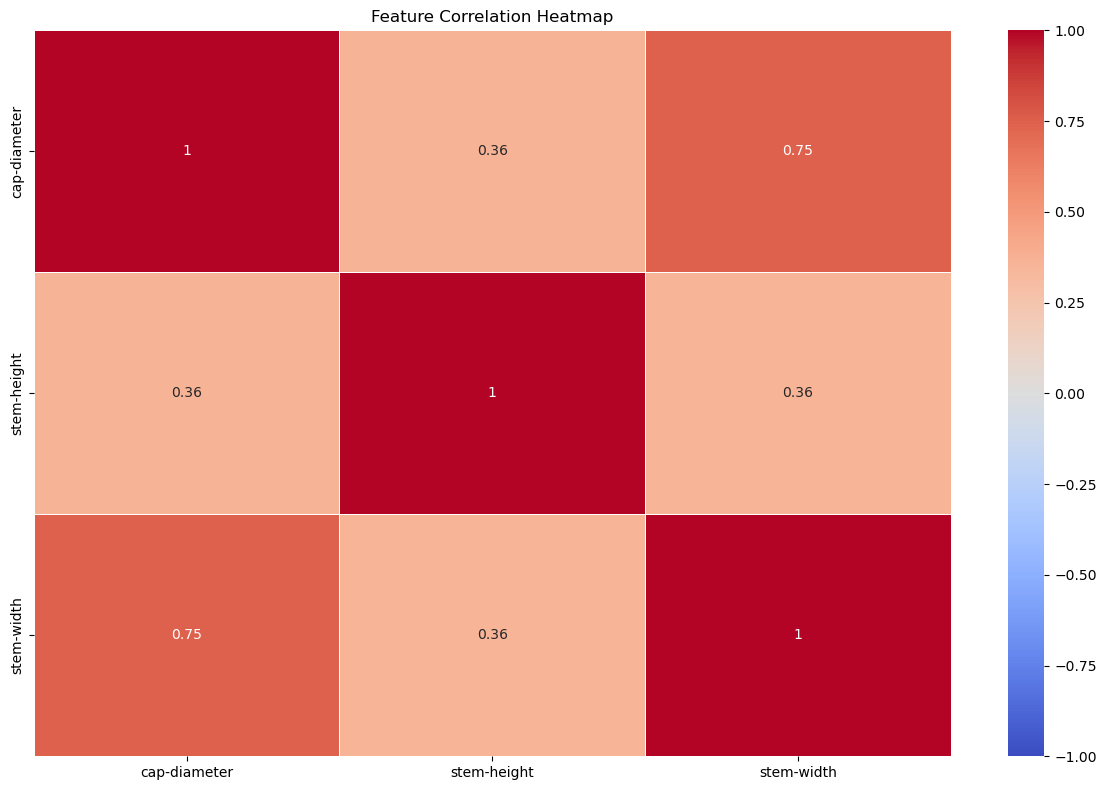

In [44]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Plot the numerical heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

<a id="hist"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Distribution Histogram</b></h3>
</div>

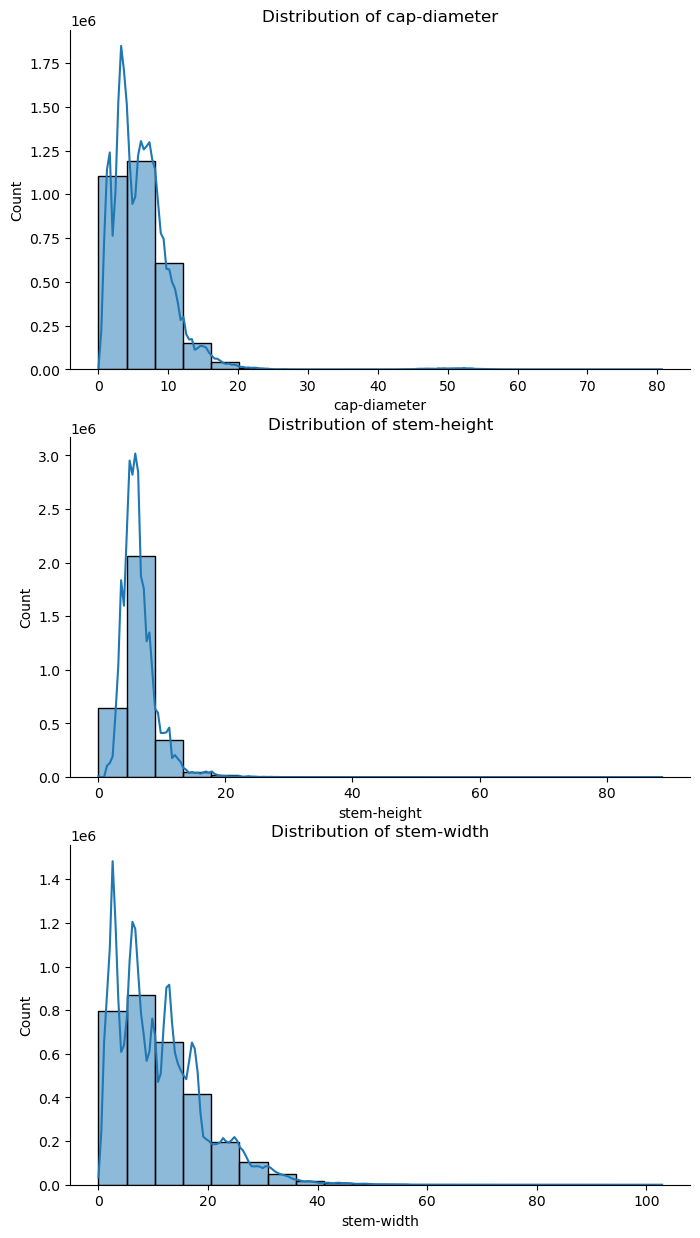

In [45]:
# Plot each numerical column by distribution

num_columns = [col for col in train.columns if train[col].nunique() > 15]
plt.figure(figsize=(8, 15)) 
for i, column in enumerate(num_columns):
    plt.subplot(3, 1, i+1)
    sns.histplot(data=train, x=column, kde=True, bins=20)
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.show()

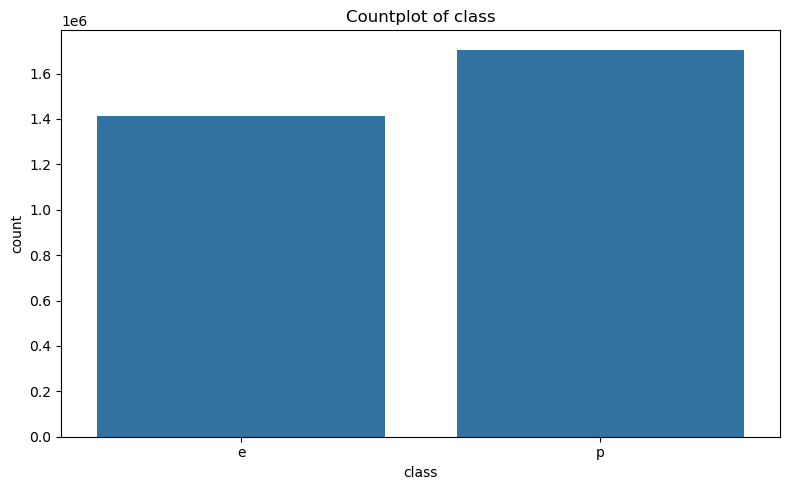

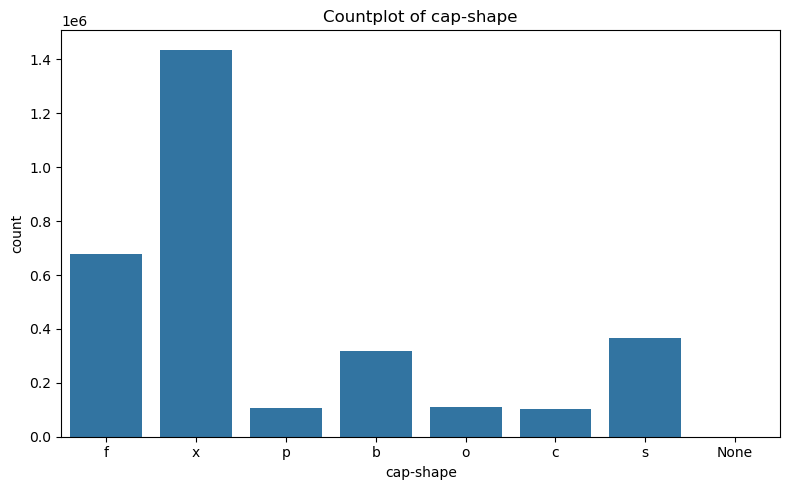

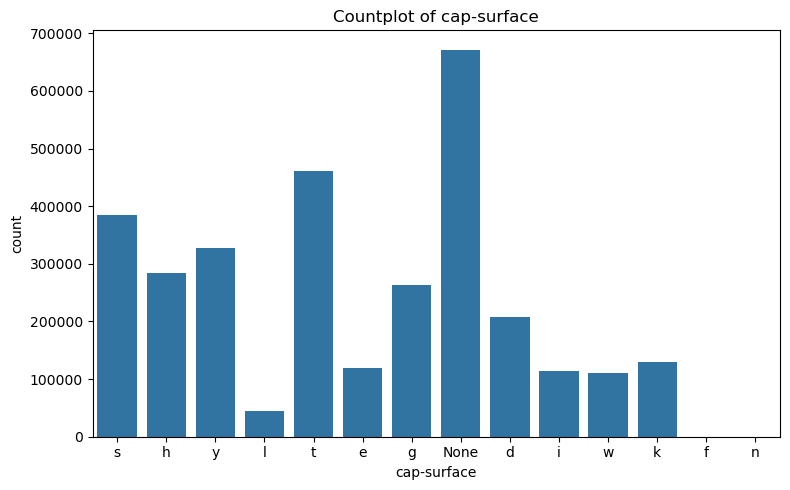

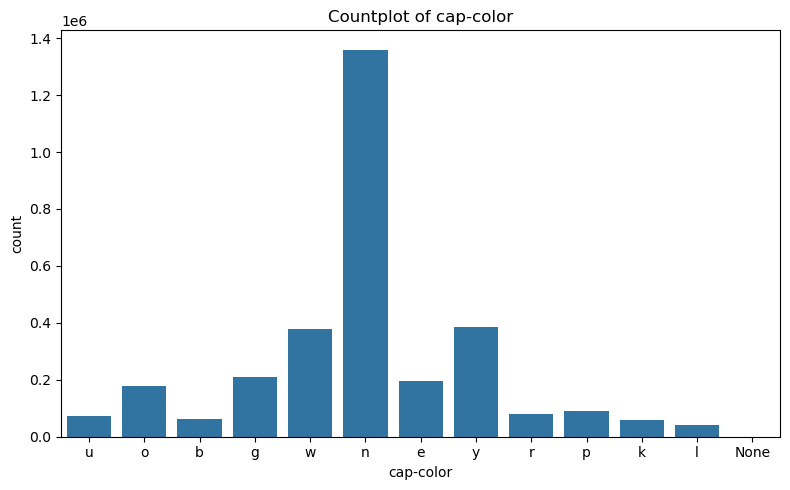

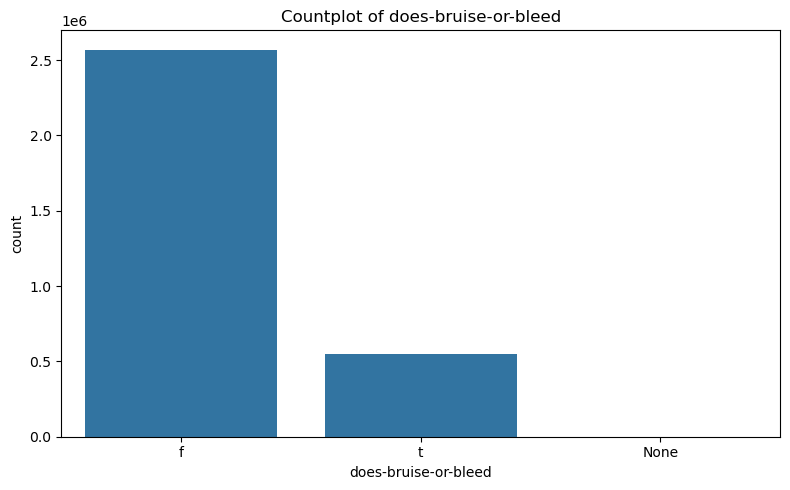

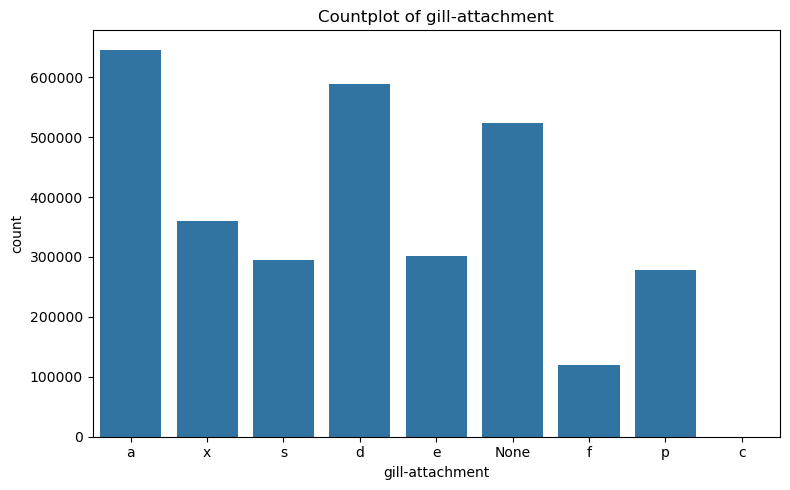

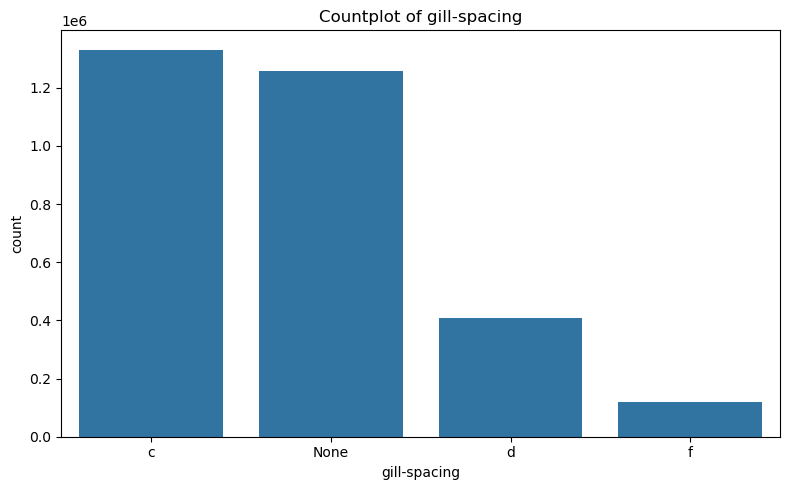

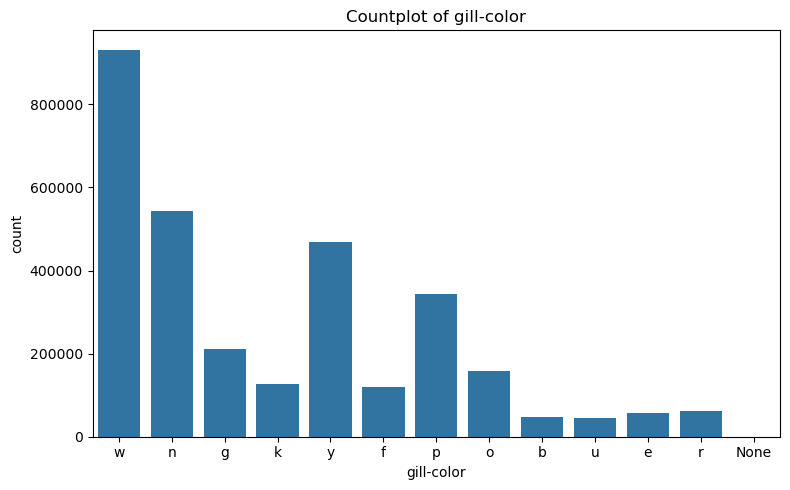

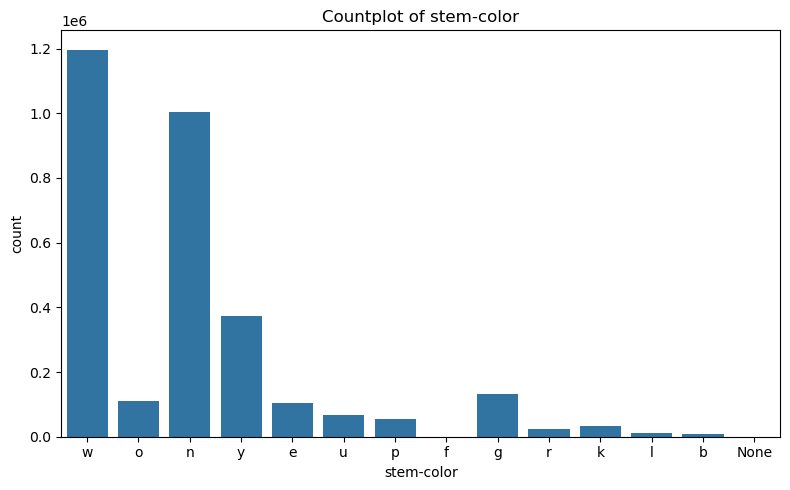

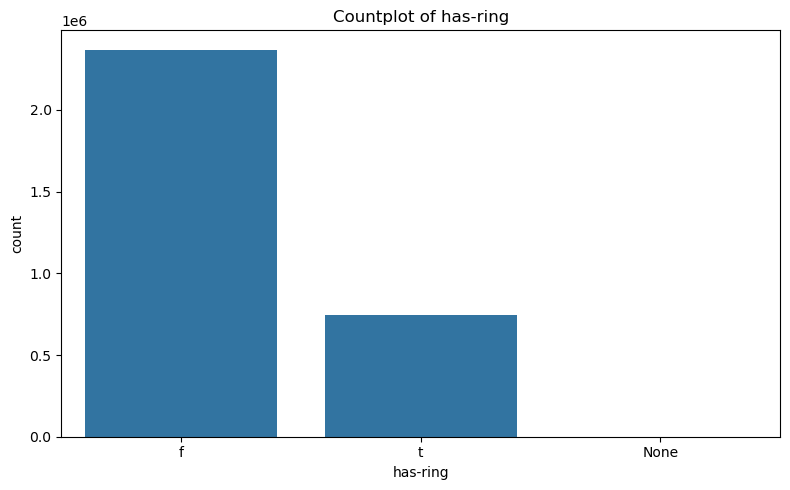

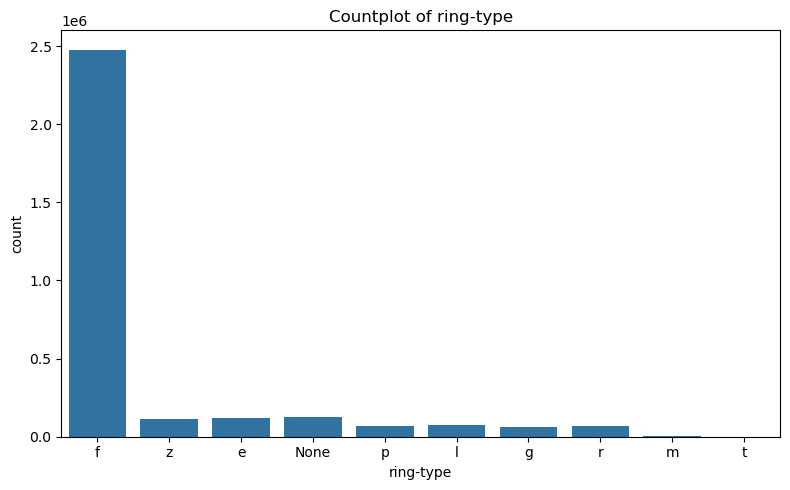

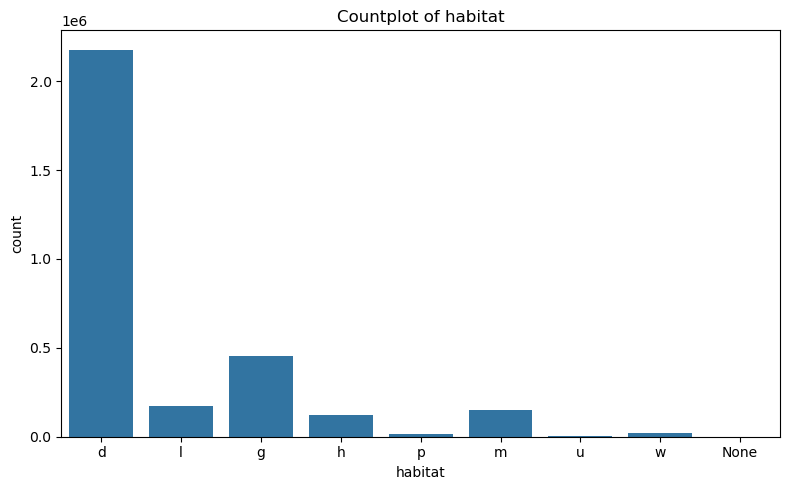

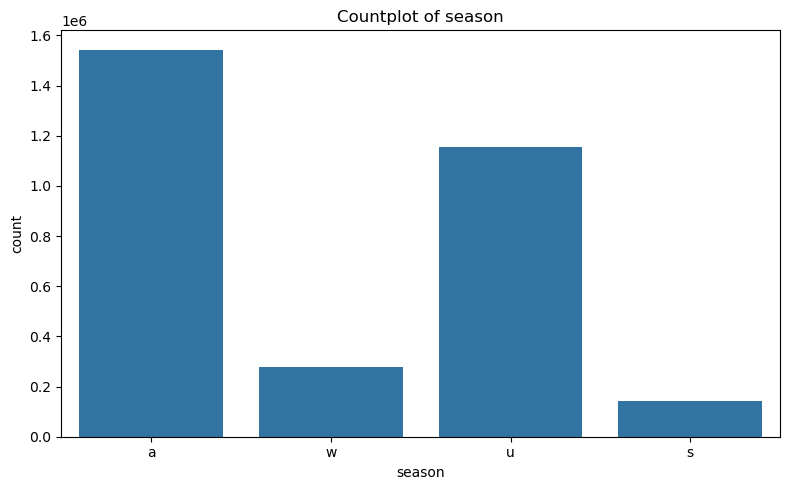

In [46]:
# Plot countplots for each categorical column

for column in cat_columns[1:]:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()

<a id="numrels"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Investigating Relationships (Numerical)</b></h3>
</div>

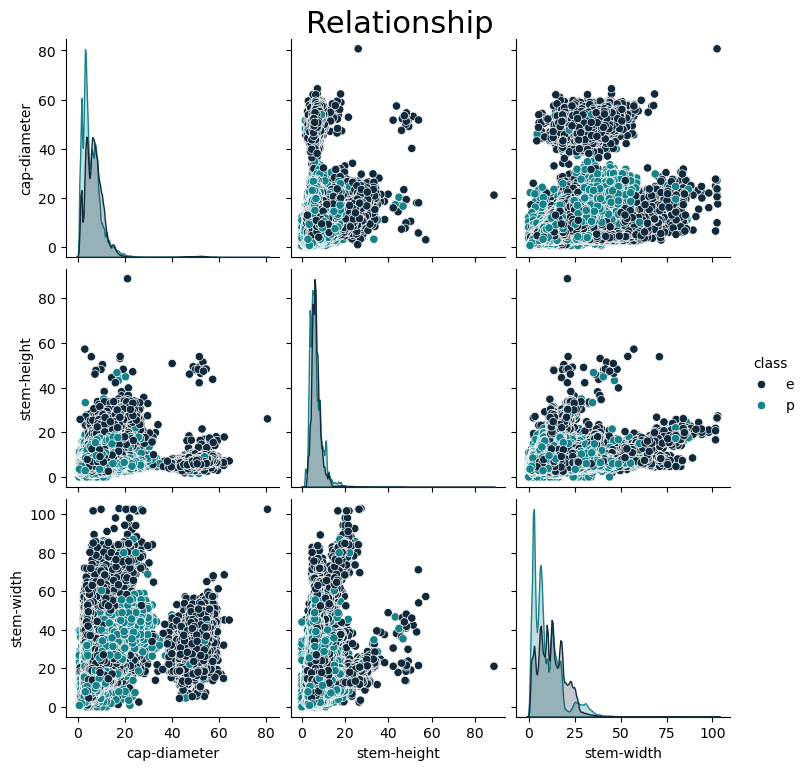

In [48]:
# Display the correlations in float dtype columns 

custom_palette = sns.color_palette(["#102A3B", "#168188"])
pairplot = sns.pairplot(train, hue='class', palette=custom_palette)
pairplot.figure.suptitle('Relationship', fontsize=22, y=1.02)
plt.show()

<a id="catrels"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Investigating Relationships (Category)</b></h3>
</div>

<Figure size 800x600 with 0 Axes>

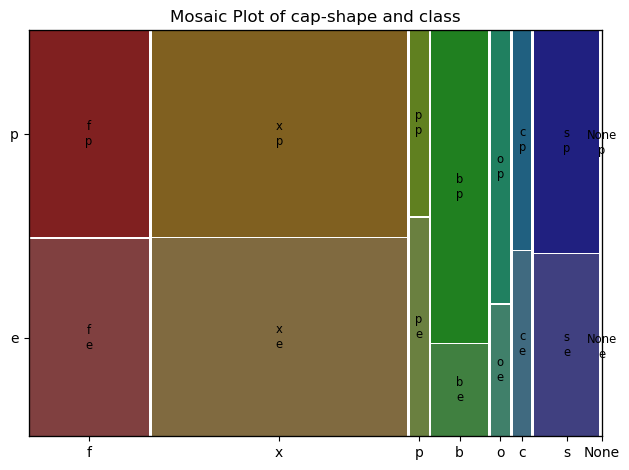

<Figure size 800x600 with 0 Axes>

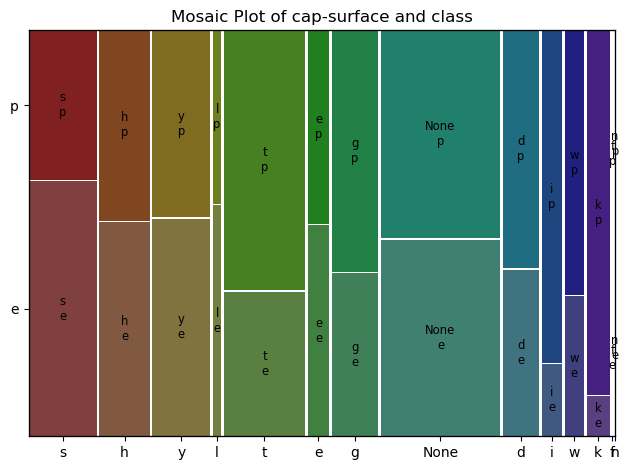

<Figure size 800x600 with 0 Axes>

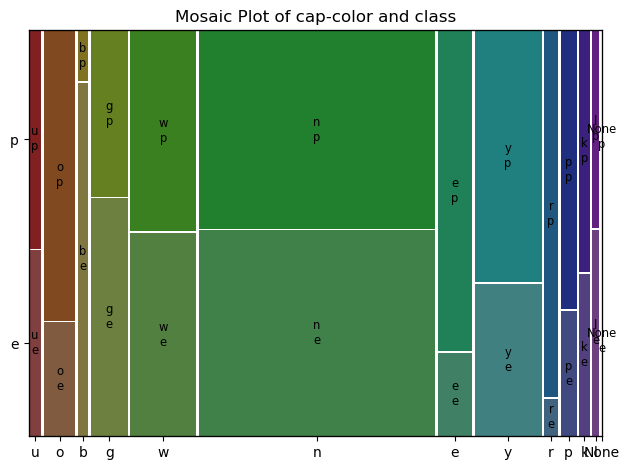

<Figure size 800x600 with 0 Axes>

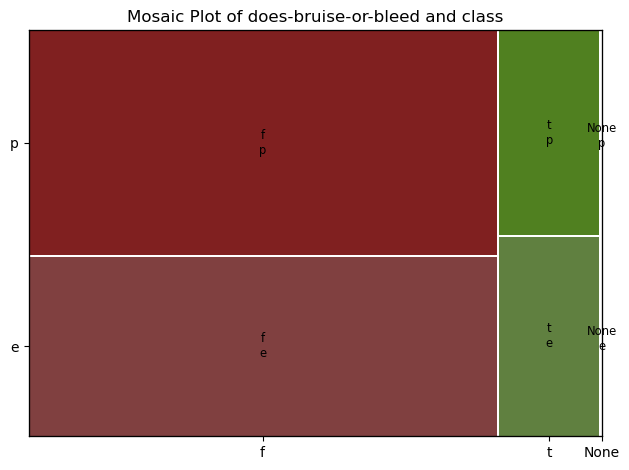

<Figure size 800x600 with 0 Axes>

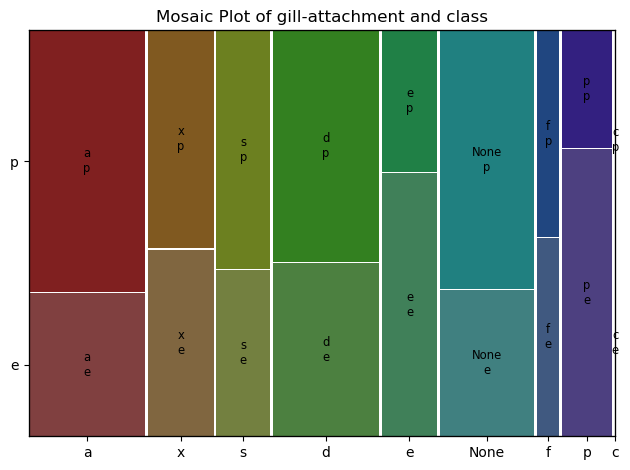

<Figure size 800x600 with 0 Axes>

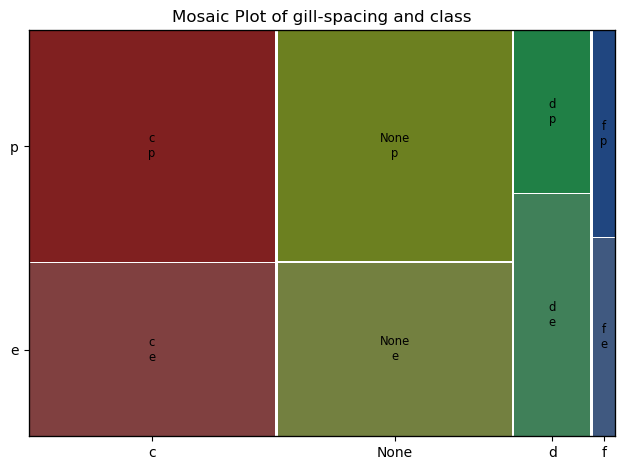

<Figure size 800x600 with 0 Axes>

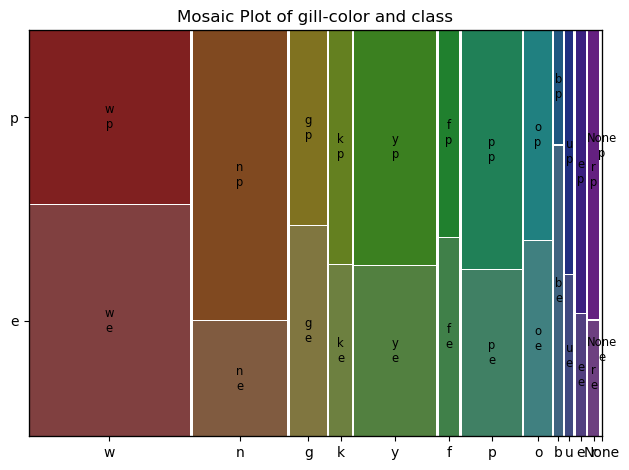

<Figure size 800x600 with 0 Axes>

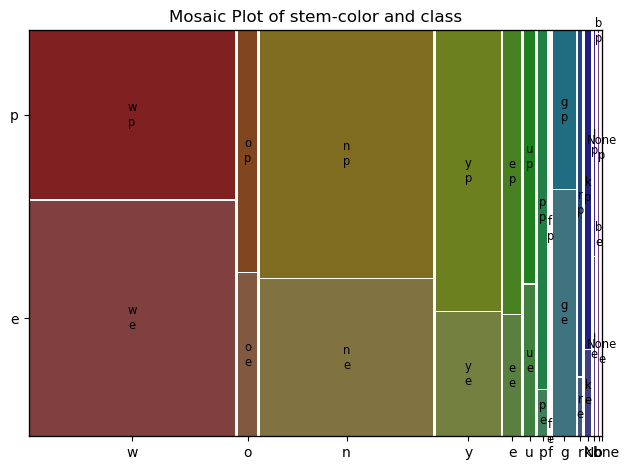

<Figure size 800x600 with 0 Axes>

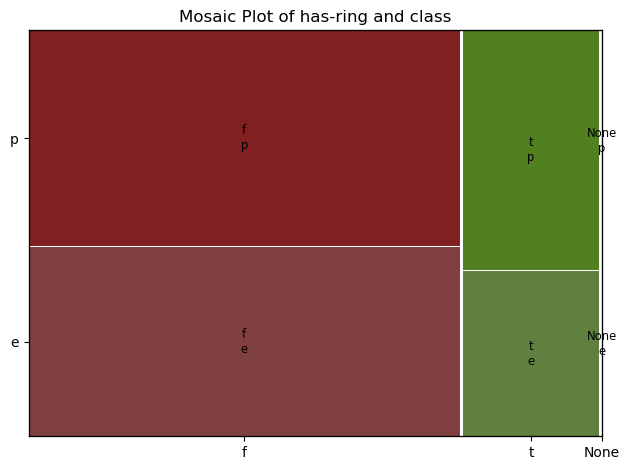

<Figure size 800x600 with 0 Axes>

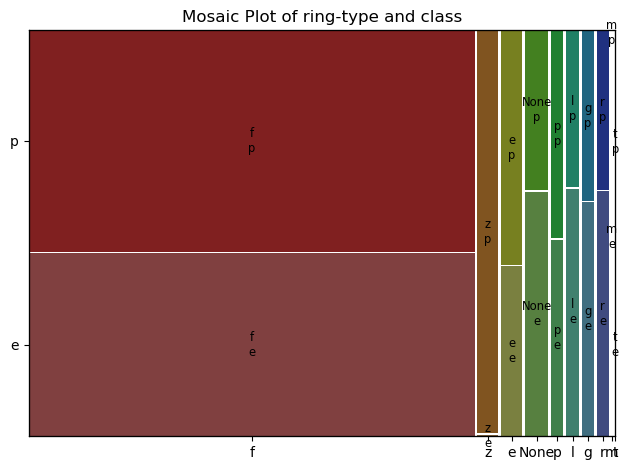

<Figure size 800x600 with 0 Axes>

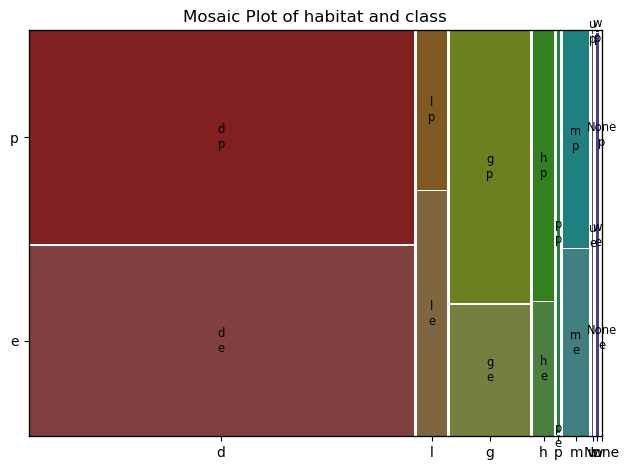

<Figure size 800x600 with 0 Axes>

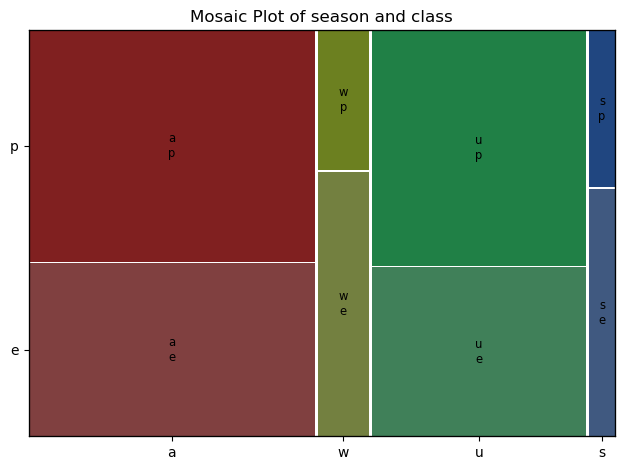

In [52]:
# Use the mosaic plot for data relations

for column in cat_columns[1:]:
    plt.figure(figsize=(8, 6))
    mosaic(train, [column, 'class'])
    plt.title(f'Mosaic Plot of {column} and class')

    plt.tight_layout()
    plt.show()

<a id="outliers"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Check For Outliers</b></h3>
</div>

In [14]:
# Calculate the z score for outliers

z_scores = stats.zscore(train[num_columns])
z_scores.describe().round(3)

,cap-diameter,stem-height,stem-width
count,3116826.0,3116826.0,3116826.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,-0.0,0.0
25%,0.0,0.0,0.0
50%,-0.0,0.0,-0.0
75%,0.0,0.0,-0.0
max,0.0,-0.0,0.0


In [15]:
# Set the numerical column as another dataframe

num_data = train[num_columns]
z_scores_df = pd.DataFrame(z_scores, columns=num_data.columns)
threshold = 3
train = train[(z_scores_df.abs() < threshold).all(axis=1)]

<a id="response"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Response Variable</b></h3>
</div>

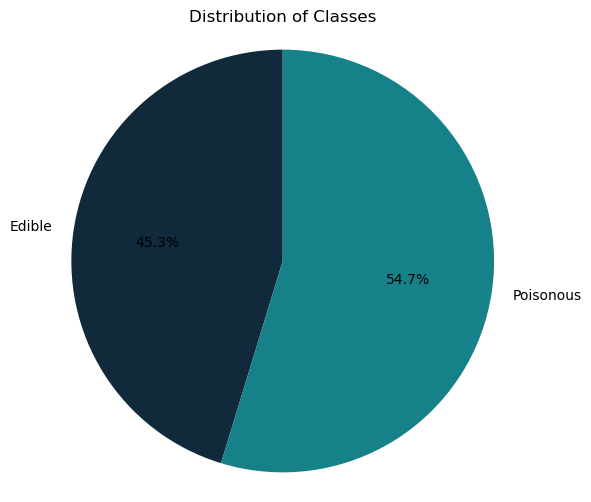

In [21]:
# Calculate counts for the pie chart and add labels

custom_palette = sns.color_palette(["#102A3B", "#168188"])
class_counts = train['class'].value_counts().sort_index()
labels = ["Edible", "Poisonous"]

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, colors=custom_palette,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Classes')
plt.axis('equal')
plt.show()

<a id="preproces"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Preproces and Model</b></h1>
</div>

In [16]:
# Encode training data

label_encoder = LabelEncoder()
enc_target = label_encoder.fit_transform(train[['class']])
train[cat_columns] = train[cat_columns].astype('category')

num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('convert', FunctionTransformer(lambda x: x.astype(np.float32)))
])

cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int32, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ]
)

df_train_encoded = preprocessor.fit_transform(train)

train_encoded_dense = df_train_encoded.toarray()

cat_feature = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_columns)

feature = np.concatenate([num_columns, cat_feature])

print("Number of Features:", len(feature))

train = pd.DataFrame(train_encoded_dense, columns=feature)

Number of Features: 96


In [17]:
# Remove unnecesarry variables
del label_encoder, df_train_encoded, train_encoded_dense, cat_pipeline, cat_feature, col, missing, z_scores, z_scores_df, num_data

<a id="models"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Testing All Models</b></h1>
</div>

<a id="split"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Train Test Split</b></h3>
</div>

In [18]:
# Set the dataframes from training data

X_data = pd.DataFrame(train)
y_data = pd.DataFrame(enc_target, columns=['class'])

In [19]:
# Remove variables for recycle memory 
del train, enc_target

In [20]:
# Split The Training And Testing Data

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

<a id="xgb"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>X Gradient Boosting</b></h3>
</div>

In [28]:
from xgboost import XGBClassifier

In [29]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mcc = matthews_corrcoef(y_test, xgb_pred)
print(f'Matthews correlation coefficient: {xgb_mcc}')

Matthews correlation coefficient: 1.0


In [36]:
# Save model to file
pkl.dump(xgb_model, open(f'{_tested}XGBClassifier.pkl', 'wb'))

<a id="light"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Light Gradient Boosting</b></h3>
</div>

In [18]:
from lightgbm import LGBMClassifier

In [32]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_mcc = matthews_corrcoef(y_test, lgb_pred)
print(f'Matthews correlation coefficient: {lgb_mcc}')

[LightGBM] [Info] Number of positive: 1363589, number of negative: 1129871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 2493460, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546866 -> initscore=0.188017
[LightGBM] [Info] Start training from score 0.188017
Matthews correlation coefficient: 0.9999935228533678


In [37]:
# Save model to file
pkl.dump(lgb_model, open(f'{_tested}LGBMClassifier.pkl', 'wb'))

<a id="cat"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Cat Boosting Classifier</b></h3>
</div>

In [33]:
from catboost import CatBoostClassifier

In [34]:
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_mcc = matthews_corrcoef(y_test, cat_pred)
print(f'Matthews correlation coefficient: {cat_mcc}')

Learning rate set to 0.290649
0:	learn: 0.0434213	total: 1.27s	remaining: 21m 14s
1:	learn: 0.0040009	total: 1.68s	remaining: 14m
2:	learn: 0.0009197	total: 2.06s	remaining: 11m 22s
3:	learn: 0.0002038	total: 2.44s	remaining: 10m 8s
4:	learn: 0.0001018	total: 2.79s	remaining: 9m 15s
5:	learn: 0.0000558	total: 3.14s	remaining: 8m 40s
6:	learn: 0.0000423	total: 3.5s	remaining: 8m 16s
7:	learn: 0.0000384	total: 3.82s	remaining: 7m 53s
8:	learn: 0.0000384	total: 4.14s	remaining: 7m 35s
9:	learn: 0.0000384	total: 4.46s	remaining: 7m 21s
10:	learn: 0.0000384	total: 4.78s	remaining: 7m 10s
11:	learn: 0.0000384	total: 5.14s	remaining: 7m 3s
12:	learn: 0.0000384	total: 5.47s	remaining: 6m 55s
13:	learn: 0.0000384	total: 5.78s	remaining: 6m 47s
14:	learn: 0.0000384	total: 6.11s	remaining: 6m 41s
15:	learn: 0.0000384	total: 6.44s	remaining: 6m 36s
16:	learn: 0.0000384	total: 6.76s	remaining: 6m 30s
17:	learn: 0.0000384	total: 7.08s	remaining: 6m 26s
18:	learn: 0.0000384	total: 7.41s	remaining: 6m

In [35]:
# Save model to file
pkl.dump(cat_model, open(f'{_tested}CatBoostClassifier.pkl', 'wb'))

<a id="confusion"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Plot Confusion Matrix</b></h3>
</div>

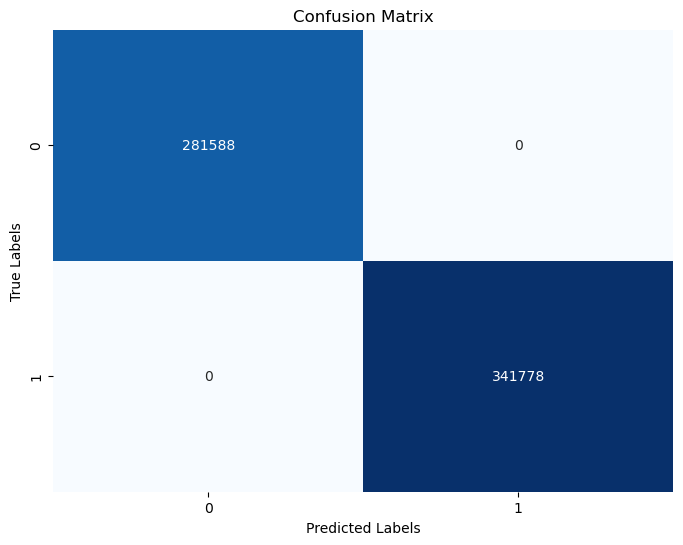

In [36]:
# Plot the confusion matrix

cm = confusion_matrix(y_test, cat_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<a id="cross"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Cross Validation</b></h1>
</div>

In [ ]:
# Convert the feature and target data

X_data = X_data.values
y_data = y_data.values.ravel()

In [24]:
# Set the parameters

params_lgbm = {
    'objective': 'binary', 
    'boosting_type': 'gbdt',
    'metric': 'binary_error', 
    'verbose': -1 
}

In [62]:
%%time

NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=1)

val_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
    X_train, X_val = X_data[train_idx], X_data[val_idx]
    y_train, y_val = y_data[train_idx], y_data[val_idx]

    model = LGBMClassifier(**params_lgbm)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    mcc = matthews_corrcoef(y_val, y_pred)
    
    val_scores.append(mcc)
    print(f'Fold {fold + 1}: MCC = {mcc:.5f}')

print("Cross-validation MCC scores:", val_scores)
print("Average MCC score:", sum(val_scores) / len(val_scores))

Fold 1: MCC = 1.00000
Fold 2: MCC = 1.00000
Fold 3: MCC = 0.99999
Fold 4: MCC = 1.00000
Fold 5: MCC = 1.00000
Cross-validation MCC scores: [0.9999967628310966, 0.9999967628267986, 0.9999935256621, 0.9999967628267986, 1.0]
Average MCC score: 0.9999967628293588
CPU times: user 2min 7s, sys: 16.5 s, total: 2min 23s
Wall time: 10min 23s


In [25]:
# Delete other dataframes
del X_train, X_test, y_train, y_test

In [26]:
# Train with all the data
model = LGBMClassifier(**params_lgbm)
model.fit(X_data, y_data)

LGBMClassifier(metric='binary_error', objective='binary', verbose=-1)

<a id="submission"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Send Submission</b></h1>
</div>

In [26]:
# Apply all clening on the test dataset

def preprocess_test(path):
    df = import_data(path, index_col="id")
    df = df.drop(drop, axis=1)
    for col in cat_columns:
        if col != target:
            df = remove_categories(df, col, threshold=70)

    df[numeric_cols] = df[numeric_cols].fillna(medians)
    df = df.fillna("None")
    df[target] = 'None'
    df[cat_columns] = df[cat_columns].astype('category')
    df_test_encoded = preprocessor.transform(df)
    test_encoded_dense = df_test_encoded.toarray()
    df = pd.DataFrame(test_encoded_dense, columns=feature)
    return df

test = preprocess_test(_test)

Memory usage of dataframe is 332.93 MB
Memory usage after optimization is: 297.26 MB
Decreased by 10.7%


In [ ]:
# Make the prediction dataframe
predicted = model.predict(test)
predicted = pd.DataFrame(predicted, columns=['class'])

In [ ]:
# Get the value counts
class_counts = predicted.value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
colors = sns.color_palette('pastel', len(class_counts))
class_counts.plot(kind='bar', color=colors)
plt.title('Class Distribution in train_df')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [33]:
# Set the 

sample_submission = import_data(_submission, index_col='id')
test_preds_series = pd.Series(predicted, index=sample_submission.index)
sample_submission['class'] = test_preds_series.map({0: 'p', 1: 'e'})
sample_submission.head()

Memory usage of dataframe is 31.71 MB
Memory usage after optimization is: 31.71 MB
Decreased by 0.0%


,class
id,
3116945,p
3116946,p
3116947,p
3116948,p
3116949,p


In [35]:
sample_submission.to_csv('submission.csv')